# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Importar librerías de código

In [1]:
#### Dataset que se va a utilizar para el entrenamiento

In [23]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from random import randint

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
# Código para obtener el Dataset que se va a usar en el entrenamiento.
# Los colores van de 0 - 255.
valor_min = 0 
valor_max = 256

# Solo tendremos 3 patrones de colores R, G y B.
valores_color = 3
num_colores = 100

# Generamos una matriz que contiene tantas filas como número de componentes del color y una columna por cada numero de colores.
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))


## SOM Setup
#### Variables definidas por el alumno

In [25]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate.
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no.

lado_mapa = 25 # Lado de la futura matriz de pesos.
periodo = 10000 # Número de veces que se va a repetir en ciclo de entrenamiento.
learning_rate = 0.1 # La neurona se desplazará un 10% al aprender.
normalizar_datos = True # Variable boolena, que utilizaremos mas adelante.

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [26]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.

# El número de entradas será igual a el numero de componentes del vector R, G y B.
num_entradas = valores_color
num_datos = num_colores  

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen.
vecindario = lado_mapa / 2 

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz.
if normalizar_datos:  
    datos = datos / (valor_max - 1)
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy.
matriz_pesos = np.random.random([lado_mapa,lado_mapa,num_entradas])



#### Funciones para entrenar/clasificar

Función calcular_bmu: En esta función, dado un patrón de entrada vamos a obtener la neurona ganadora y su posición. La neurona ganadora se calcula usando el criterio de la mínima distancia ecuclídea.

In [27]:
# Función para encontrar la BMU.
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
    
    # Incializamos las variables.
    dist = [0] * num_entradas
    bmu = [0] * num_entradas
    bmu_idx = [0] * 2
    
    # Tanto el for para las 'x' y para las 'y' sirven para recorrer la matriz de ancho y alto.
    for x in range (0, len(m_pesos[:, 0])):
        for y in range (0, len(m_pesos[0, :])):
            
            for z in range (0, m):
                # Calculamos una distancia euclidea para cada entrada. Obviamos la raiz cuadrada para ahorrarnos calculos.
                dist[z] = np.array((patron_entrada[z] - m_pesos[x, y, z])**2)
                
            # La distacia ecuclidea final será la suma de todas las distancias de las entradas de la neurona.
            distancia_euclidea = sum(dist)
            
            # Este if se ejecuta solo una vez y es para tener un primer mínimo con el que comparar el resto.
            if x == 0 and y == 0:
                
                # neurona_ganadora nos sirve para realizar comparaciones, cada vez que encontremos una distancia menor se 
                # actualizará el valor de la neurona ganadora con esa distancia.
                neurona_ganadora = distancia_euclidea
                # bmu es un vector que guarda la matriz de pesos de la neurona ganadora.
                bmu = np.array(m_pesos[x, y])
                # bmu_idx es un vector que guarda la posicion de la neurona ganadora.
                bmu_idx = np.array([x, y])
            
            # Si no es la primera vez que se ejecuta el if entraremos en el else y se hará una comparación.
            else:
                
                # Comparamos la distancia euclídea recién calculada con la que es nuestra neurona ganadora. Si es menor querrá
                # decir que hemos encontrado una neurona mejor.
                if distancia_euclidea < neurona_ganadora: 
                    
                    neurona_ganadora = distancia_euclidea
                    bmu = np.array(m_pesos[x, y])
                    bmu_idx = np.array([x, y])

    # Devolvemos los valores de la bmu y bmu_idx.
    return bmu, bmu_idx 

In [28]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta).
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    
    learning_rate_final = 0
    learning_rate = lr_inicial + (((learning_rate_final - lr_inicial) / n_iteraciones) * i)
    
    return learning_rate

In [29]:
# Función para calcular el descenso del vecindario (v).
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    
    lvecindario = 1 + vecindario_inicial * (1 - (i / n_iteraciones))
    
    return lvecindario

In [30]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU.
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(- distancia_BMU / (2 * (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [31]:
# Función para pintar una matriz de valores como colores RGB.
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes.
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB.
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento


Mapa de colores RGB de la Matriz de pesos iniciales: 


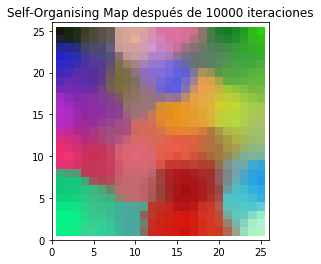


Iteración:  0

Iteración:  100

Iteración:  200

Iteración:  300

Iteración:  400

Iteración:  500

Iteración:  600

Iteración:  700

Iteración:  800

Iteración:  900

Iteración:  1000

Iteración:  1100

Iteración:  1200

Iteración:  1300

Iteración:  1400

Iteración:  1500

Iteración:  1600

Iteración:  1700

Iteración:  1800

Iteración:  1900

Iteración:  2000

Iteración:  2100

Iteración:  2200

Iteración:  2300

Iteración:  2400

Iteración:  2500

Iteración:  2600

Iteración:  2700

Iteración:  2800

Iteración:  2900

Iteración:  3000

Iteración:  3100

Iteración:  3200

Iteración:  3300

Iteración:  3400

Iteración:  3500

Iteración:  3600

Iteración:  3700

Iteración:  3800

Iteración:  3900

Iteración:  4000

Iteración:  4100

Iteración:  4200

Iteración:  4300

Iteración:  4400

Iteración:  4500

Iteración:  4600

Iteración:  4700

Iteración:  4800

Iteración:  4900

Iteración:  5000

Iteración:  5100

Iteración:  5200

Iteración:  5300

Iteración:  5400

Iteración:  5500

Ite

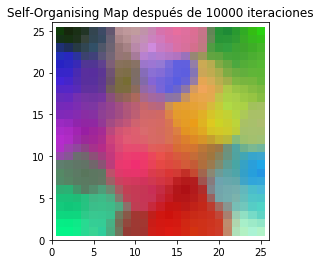

In [36]:
# Entrena la red con el dataset de entrenamiento.

# Dibujamos la matriz de pesos iniciales como un mapa de colores RGB con pintar_mapa
print('\nMapa de colores RGB de la Matriz de pesos iniciales: ')
pintar_mapa(matriz_pesos)

# Inicializamos las variables.
aleatorio = [0] * num_entradas
for i in range (0, periodo):

    # Imprimimos cada 100 iteraciones el numero de iteración.
    if i%100 == 0:
        print('\nIteración: ', i)
        
    # Generamos el patron aleatorio para posteriormente calcular la bmu.
    numero = np.random.randint(0, num_datos - 1)
    for j in range (0, num_entradas):
        aleatorio[j] = datos[j][numero]
        
    # Buscamos la Best Matching Unit.
    bmu, bmu_idx = calcular_bmu(aleatorio, matriz_pesos, num_entradas)
   
    # Calculamos eta y v para cada interacción del bucle.
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario, i, periodo)

    # Actualizamos los pesos de la neurona ganadora.
    matriz_pesos[bmu_idx[0], bmu_idx[1]] = bmu + eta * (np.array(aleatorio) - bmu)
    
    # Actualizamos los pesos de las neuronas vecinas.
    for x in range (0, len(matriz_pesos[:, 0])):
        for y in range (0, len(matriz_pesos[0, :])):
            
                # Calculamos la distancia 2-D.
                distancia = ((bmu_idx[0] - x)**2) + ((bmu_idx[1] - y)**2)
               
                if distancia <= v :
                    # Calculamos la amortiguación.
                    amort = decay(distancia, v)
                    # Actualizamos neuronas vecinas.
                    matriz_pesos[x,y] = matriz_pesos[x, y] + (eta * amort) * (bmu - matriz_pesos[x, y])

                    
# Imprimimos la matriz de pesos entrenada.
print('\n\nMatriz de pesos entrenada: \n')
print(matriz_pesos)

# Dibujamos el mapa de colores RGB de la matriz de pesos entrenados.
print('\n\nMapa de colores RGB de la Matriz de pesos entrenados: ')
pintar_mapa(matriz_pesos)

## SOM Clasificación


Coordenas de la BMU para el patrón de prueba  [0.33725490196078434, 0.45098039215686275, 0.3411764705882353]
x =  3
y =  7

Coordenas de la BMU para el patrón de prueba  [0.70196078431372544, 0.92941176470588238, 0.29019607843137257]
x =  20
y =  15

Coordenas de la BMU para el patrón de prueba  [0.85882352941176465, 0.11372549019607843, 0.094117647058823528]
x =  13
y =  0

Coordenas de la BMU para el patrón de prueba  [0.71764705882352942, 0.96470588235294119, 0.77254901960784317]
x =  24
y =  0

Coordenas de la BMU para el patrón de prueba  [0.49019607843137253, 0.21568627450980393, 0.63529411764705879]
x =  4
y =  15

Coordenas de la BMU para el patrón de prueba  [0.67450980392156867, 0.15294117647058825, 0.15686274509803921]
x =  17
y =  5

Coordenas de la BMU para el patrón de prueba  [0.7686274509803922, 0.16078431372549021, 0.086274509803921567]
x =  17
y =  3

Coordenas de la BMU para el patrón de prueba  [0.82352941176470584, 0.41960784313725491, 0.69019607843137254]
x =  12


Coordenas de la BMU para el patrón de prueba  [0.10196078431372549, 0.46666666666666667, 0.92156862745098034]
x =  24
y =  7

Coordenas de la BMU para el patrón de prueba  [0.77647058823529413, 0.94901960784313721, 0.69019607843137254]
x =  22
y =  0

Coordenas de la BMU para el patrón de prueba  [0.85882352941176465, 0.11372549019607843, 0.094117647058823528]
x =  13
y =  0

Coordenas de la BMU para el patrón de prueba  [0.59999999999999998, 0.7686274509803922, 0.47450980392156861]
x =  24
y =  11

Coordenas de la BMU para el patrón de prueba  [0.10980392156862745, 0.019607843137254902, 0.023529411764705882]
x =  1
y =  24

Coordenas de la BMU para el patrón de prueba  [0.59607843137254901, 0.45490196078431372, 0.46666666666666667]
x =  7
y =  21

Coordenas de la BMU para el patrón de prueba  [0.95294117647058818, 0.13725490196078433, 0.44705882352941179]
x =  9
y =  8

Coordenas de la BMU para el patrón de prueba  [0.81960784313725488, 0.42745098039215684, 0.34509803921568627]
x =  

Coordenas de la BMU para el patrón de prueba  [0.24705882352941178, 0.13725490196078433, 0.90980392156862744]
x =  0
y =  18

Coordenas de la BMU para el patrón de prueba  [0.52156862745098043, 0.15686274509803921, 0.71372549019607845]
x =  1
y =  14

Coordenas de la BMU para el patrón de prueba  [0.34509803921568627, 0.16862745098039217, 0.61960784313725492]
x =  4
y =  19

Coordenas de la BMU para el patrón de prueba  [0.7686274509803922, 0.24705882352941178, 0.32156862745098042]
x =  8
y =  5

Coordenas de la BMU para el patrón de prueba  [0.14901960784313725, 0.80000000000000004, 0.63921568627450975]
x =  5
y =  0

Coordenas de la BMU para el patrón de prueba  [0.69019607843137254, 0.086274509803921567, 0.11764705882352941]
x =  16
y =  5

Coordenas de la BMU para el patrón de prueba  [0.792156862745098, 0.16470588235294117, 0.33725490196078434]
x =  11
y =  5

Coordenas de la BMU para el patrón de prueba  [0.27843137254901962, 0.76078431372549016, 0.7686274509803922]
x =  24
y =  

Coordenas de la BMU para el patrón de prueba  [0.89411764705882357, 0.61568627450980395, 0.19607843137254902]
x =  15
y =  15

Coordenas de la BMU para el patrón de prueba  [0.015686274509803921, 0.94901960784313721, 0.54117647058823526]
x =  1
y =  0

Coordenas de la BMU para el patrón de prueba  [0.7686274509803922, 0.41176470588235292, 0.42745098039215684]
x =  10
y =  15

Coordenas de la BMU para el patrón de prueba  [0.22352941176470589, 0.69803921568627447, 0.035294117647058823]
x =  23
y =  24

Coordenas de la BMU para el patrón de prueba  [0.32941176470588235, 0.35686274509803922, 0.90196078431372551]
x =  14
y =  18

Coordenas de la BMU para el patrón de prueba  [0.59215686274509804, 0.10588235294117647, 0.64313725490196083]
x =  3
y =  12

Coordenas de la BMU para el patrón de prueba  [0.93333333333333335, 0.83529411764705885, 0.094117647058823528]
x =  18
y =  13

Coordenas de la BMU para el patrón de prueba  [0.4392156862745098, 0.43137254901960786, 0.4392156862745098]
x = 

x =  19
y =  1

Coordenas de la BMU para el patrón de prueba  [0.55686274509803924, 0.23921568627450981, 0.20392156862745098]
x =  8
y =  0

Coordenas de la BMU para el patrón de prueba  [0.9882352941176471, 0.34509803921568627, 0.30980392156862746]
x =  12
y =  9

Coordenas de la BMU para el patrón de prueba  [0.59999999999999998, 0.7686274509803922, 0.47450980392156861]
x =  24
y =  11

Coordenas de la BMU para el patrón de prueba  [0.34509803921568627, 0.19215686274509805, 0.61568627450980395]
x =  4
y =  18

Coordenas de la BMU para el patrón de prueba  [0.792156862745098, 0.16470588235294117, 0.33725490196078434]
x =  11
y =  5

Coordenas de la BMU para el patrón de prueba  [0.59215686274509804, 0.10588235294117647, 0.64313725490196083]
x =  3
y =  12

Coordenas de la BMU para el patrón de prueba  [0.63529411764705879, 0.94117647058823528, 0.79607843137254897]
x =  22
y =  1

Coordenas de la BMU para el patrón de prueba  [0.086274509803921567, 0.80000000000000004, 0.49411764705882

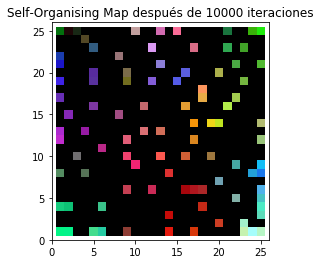



Mapa de activaciones: 

[[  3.   0.   0.  12.   0.   0.   0.   1.   0.   0.   0.   8.   6.   0.
    0.   0.   3.   0.   3.   0.   6.   4.   0.   0.  13.]
 [  5.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   7.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   5.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.]
 [  0.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.   0.  10.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   7.   0.]
 [  9.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   3.   0.   0.   7.   5.   0.   0.   5.   0.   0.]
 [  4.   0.   0.  11.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

In [39]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada.

# Inicializamos las variables.
# Definimos tres matrices y las inicializamos a 0.
mapa_de_clasificacion = np.zeros((lado_mapa, lado_mapa, num_entradas))
mapa_de_activacion = np.zeros((lado_mapa, lado_mapa))
mapa_de_distancias = np.zeros((lado_mapa, lado_mapa))

random = [0] * num_entradas
distancia_media_patrones = [0] * num_entradas
cont_neuronas_activadas = 0

# Recorremos todo el dataset con la matriz de pesos.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        
        # Generamos el numero aleatorio.
        numero = np.random.randint(0, num_datos - 1)
        
        # Cojemos una posición aleatoria de datos y la guardamos en random[i].
        for i in range (0, num_entradas):
            random[i] = datos[i][numero]
        
        # Obtenemos el patron de la bmu ganadora y su posición en la matriz.
        bmu, bmu_idx = calcular_bmu(random, matriz_pesos, num_entradas)
        
        # Imprimimos las cordenadas (x, y) de la BMU para cada patrón de prueba.
        print('\nCoordenas de la BMU para el patrón de prueba ', random)
        print('x = ', bmu_idx[0])
        print('y = ', bmu_idx[1])
        
        # Calculamos un mapa con los sumatorios de distancias medias. ATENCION: este no es el mapa_de_distancias. 
        # Calculamos la distancia
        distancia_media_patrones = sum((bmu - random)**2)
        # Guardamos la distancia calculada en un mapa de distancias, en el caso de que es esa posición ya hubiera guardada
        # una distancia anterior, sumariamos la distancia calculada a la que ya habia guardada en dicho mapa.
        mapa_de_distancias[bmu_idx[0], bmu_idx[1]] = mapa_de_distancias[bmu_idx[0], bmu_idx[1]] + distancia_media_patrones
        # Este mapa no es el verdadero mapa_de_distancias pero lo será cuando lo acabemos de calcular más adelante.
       
        # Calculamos el mapa de clasificación.
        mapa_de_clasificacion[bmu_idx[0], bmu_idx[1]] = random
       
        # Calculamos el mapa de activacion.
        mapa_de_activacion[bmu_idx[0], bmu_idx[1]] += 1


# Una vez terminado el for, tenemos creado bien el mapa_de_activacion y podemos usarlo para hacer la media de nuestras
# distancias en el mapa_de_distancias.
# Mapa de distancias.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        if mapa_de_activacion[x][y] > 0:
            mapa_de_distancias[x][y] = mapa_de_distancias[x][y] / mapa_de_activacion[x][y]
            #Contamos las neuronas que han sido activadas.
            cont_neuronas_activadas = cont_neuronas_activadas + 1
        else:
            mapa_de_distancias[x][y] = 0        


# Dibujamos el mapa de clasificación.
print('\n\nMapa de clasificacion')
pintar_mapa(mapa_de_clasificacion)

# Imprimimos los mapas de activación y de distancias.
print('\n\nMapa de activaciones: \n')
print(mapa_de_activacion)
print('\n\nMapa de distancias: \n')
print(mapa_de_distancias)

# Calculamos la distancia media del mapa (solo para aquellas neuronas activadas)
distancia_media_neuronas_activadas = sum(sum(mapa_de_distancias)) / cont_neuronas_activadas

# Imprimimos la distancia media
print('\n\nDistancia media del mapa: ', distancia_media_neuronas_activadas)

## SOM Prueba


Coordenas de la BMU para el patrón de prueba  [1 1 1]
x =  23
y =  0

Coordenas de la BMU para el patrón de prueba  [1 0 0]
x =  13
y =  0

Coordenas de la BMU para el patrón de prueba  [0 1 0]
x =  24
y =  24

Coordenas de la BMU para el patrón de prueba  [0 0 1]
x =  0
y =  20

Coordenas de la BMU para el patrón de prueba  [1 1 0]
x =  18
y =  13

Coordenas de la BMU para el patrón de prueba  [0 1 1]
x =  24
y =  8


Mapa de clasificacion


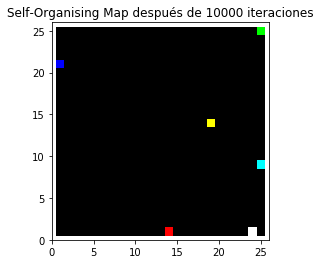



Mapa de activacion: 

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  

In [42]:
# Clasifica nuevos patrones

# Inicializamos las variables.
# Definimos tres matrices y las inicializamos a 0.
mapa_de_clasificacion = np.zeros((lado_mapa, lado_mapa, num_entradas))
mapa_de_activacion = np.zeros((lado_mapa, lado_mapa))
mapa_de_distancias = np.zeros((lado_mapa, lado_mapa))

distancia_media_patrones = [0] * num_entradas
cont_neuronas_activadas = 0

# Patrón de prueba que introducimos a la variable: [255, 255, 255] [255, 0, 0] [0, 255, 0] [0, 0, 255] [255, 255, 0] 
# [0, 255, 255].
patrones_prueba = np.array([[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1]])

for i in range (0, len(patrones_prueba)):
    # Obtenemos el patron de la bmu ganadora y su posición en la matriz.
    bmu, bmu_idx = calcular_bmu(patrones_prueba[i], matriz_pesos, num_entradas)

    # Imprimimos las cordenadas (x, y) de la BMU para cada patrón de prueba.
    print('\nCoordenas de la BMU para el patrón de prueba ', patrones_prueba[i])
    print('x = ', bmu_idx[0])
    print('y = ', bmu_idx[1])

    # Calculamos un mapa con los sumatorios de distancias medias. ATENCION: este no es el mapa_de_distancias. 
    # Calculamos la distancia.
    distancia_media_patrones = sum((bmu - patrones_prueba[i])**2)
    # Guardamos la distancia calculada en un mapa de distancias, en el caso de que es esa posición ya hubiera guardada
    # una distancia anterior, sumariamos la distancia calculada a la que ya habia guardada en dicho mapa.
    mapa_de_distancias[bmu_idx[0], bmu_idx[1]] = mapa_de_distancias[bmu_idx[0], bmu_idx[1]] + distancia_media_patrones
    # Este mapa no es el verdadero mapa_de_distancias pero lo será cuando lo acabemos de calcular más adelante.

    # Calculamos el mapa de clasificación.
    mapa_de_clasificacion[bmu_idx[0], bmu_idx[1]] = patrones_prueba[i]

    # Calculamos el mapa de activacion.
    mapa_de_activacion[bmu_idx[0], bmu_idx[1]] += 1


# Una vez terminado el for, tenemos creado bien el mapa_de_activacion y podemos usarlo para hacer la media de nuestras
# distancias en el mapa_de_distancias.
# Mapa de distancias.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        if mapa_de_activacion[x][y] > 0:
            mapa_de_distancias[x][y] = mapa_de_distancias[x][y] / mapa_de_activacion[x][y]
            #Contamos las neuronas que han sido activadas.
            cont_neuronas_activadas = cont_neuronas_activadas + 1
        else:
            mapa_de_distancias[x][y] = 0        


# Dibujamos el mapa de clasificación.
print('\n\nMapa de clasificacion')
pintar_mapa(mapa_de_clasificacion)

# Imprimimos los mapas de activación y de distancias.
print('\n\nMapa de activacion: \n')
print(mapa_de_activacion)
print('\n\nMapa de distancias: \n')
print(mapa_de_distancias)

# Calculamos la distancia media del mapa (solo para aquellas neuronas activadas).
distancia_media_neuronas_activadas = sum(sum(mapa_de_distancias))/cont_neuronas_activadas

# Imprimimos la distancia media.
print('\n\nDistancia media del mapa: ', distancia_media_neuronas_activadas)